In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.7 MB/s eta 0:00:00


In [3]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# img = cv.imread("/content/drive/MyDrive/face_recognition/dataset/sardor_abdirayimov/5.png")
# opencv BGR channel format and plt reads images as RGB channel format

In [ ]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 144ms/step


In [ ]:
results

[{'box': [463, 307, 259, 353],
  'confidence': 0.9999786019325256,
  'keypoints': {'left_eye': (581, 433),
   'right_eye': (684, 432),
   'nose': (669, 493),
   'mouth_left': (611, 577),
   'mouth_right': (683, 573)}}]

In [ ]:
x,y,w,h = results[0]['box']

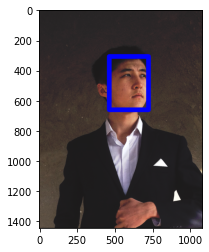

In [ ]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

In [ ]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [ ]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

# Automate the preprocessing


In [6]:
from mtcnn.mtcnn import MTCNN

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [7]:
faceloading = FACELOADING("/content/drive/MyDrive/ComputerVision/face/dataset")
X, Y = faceloading.load_classes()

Loaded successfully: 10
Loaded successfully: 9
Loaded successfully: 10


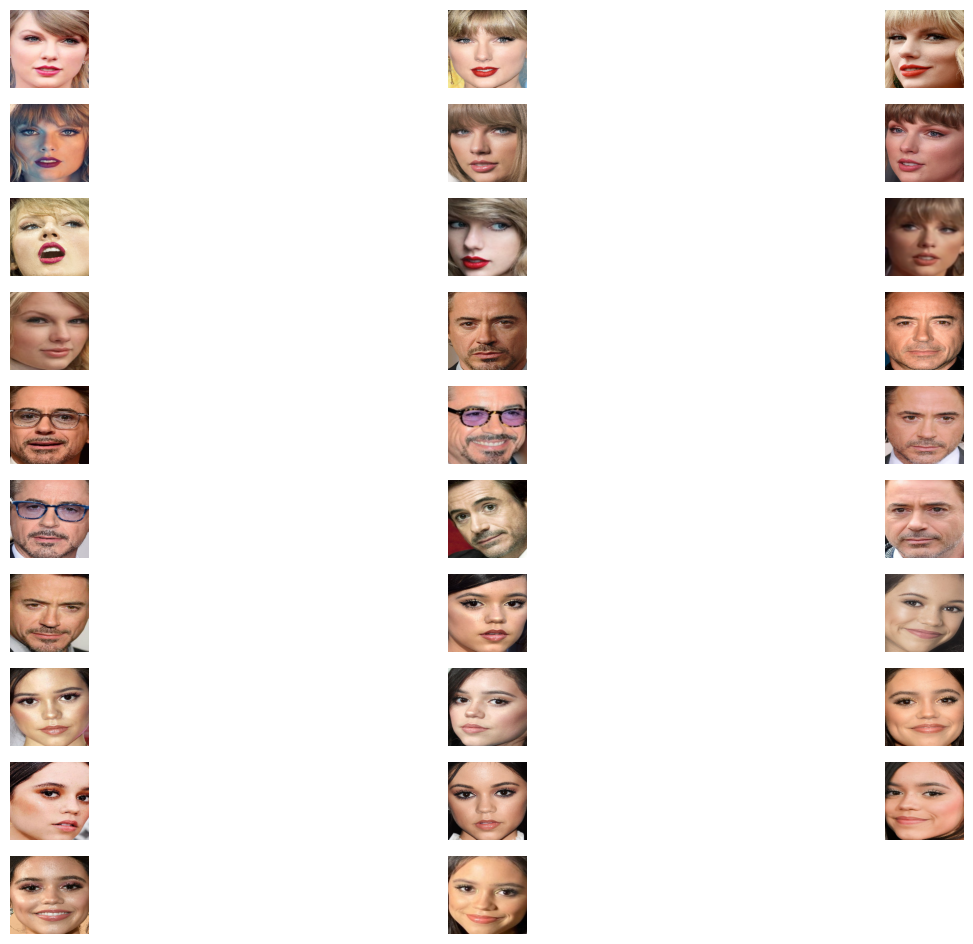

In [8]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [9]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=a1b7df90e0ac9d77b1c89d7cfd734c8e6f8df2438d74669be17159424d389c78
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [10]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [11]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms

In [12]:
np.savez_compressed('/content/drive/MyDrive/ComputerVision/face/faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

# SVM model


In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '2')

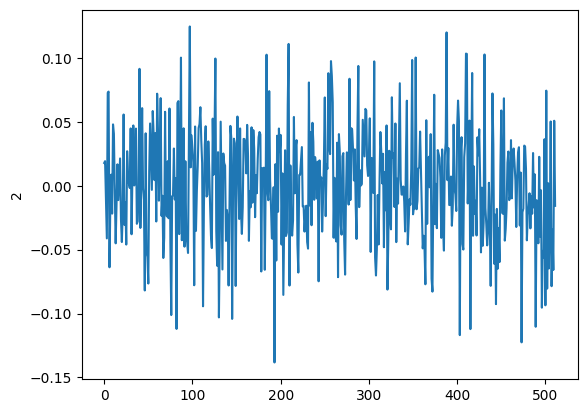

In [14]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [ ]:
break

SyntaxError: ignored

In [15]:
Y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [17]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [18]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [20]:
accuracy_score(Y_test,ypreds_test)

1.0

In [ ]:
t_im = cv.imread("/content/drive/MyDrive/ComputerVision/face/sardor_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

In [ ]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

In [ ]:
encoder.inverse_transform(ypreds)

In [22]:
import pickle
#save the model
with open('/content/drive/MyDrive/ComputerVision/face/svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)